In [1]:
# Run the command below if necessary, for example with Google Colab
#!python3 -m pip install mxnet-cu117

In [2]:
# Global Libraries
import collections
import gluoncv as gcv
import matplotlib.pyplot as plt
import mxnet as mx
import numpy as np
import os
from sklearn import metrics

# MXNet ND-Arrays with Numpy notation
mx.npx.set_np()

# Local Libraries
import utils

# GPU mode
ctx = mx.gpu()

In [3]:
# !wget https://zenodo.org/record/5226945/files/cats_dogs_light.zip?download=1 -O cats_dogs_light.zip

In [36]:
# Load Dataset: Dogs vs Cats Light Version
# Full dataset available: https://www.kaggle.com/c/dogs-vs-cats
# Light version available: https://zenodo.org/record/5226945#.Y9ZYCezP3VZ
from importlib import reload
reload(utils)

path = os.getcwd()

# Variables for dataset loading & pre-processing
imageNet=False

# Pre-processing the data, splitting training, validation and test set

# For Full Dataset (25k samples)
# Training set 20k samples (80%), Val set 2500 samples (10%), Test set 2500 samples (10%)
# light=False
# split = [0.8, 0.1, 0.1]

# For light version Dataset (1000 samples for Train+Val, 400 samples for Test)
# Training set 800 samples (80%), Val set 200 samples (20%), Test set 400 samples
light=True
split = [0.8, 0.2]

# Comment the line below if this is not the 1st execution
# It will yield wrong results if run several times (needs folder deletion)
utils.preprocess_kaggle_cats_vs_dogs(path, split, light=light)

# Generate DataLoader without pre-processing for ImageNet for visualization purposes (light dataset version)
train_dataset, val_dataset, test_dataset = utils.generate_cats_vs_dogs_datasets(path, light=light, imageNet=imageNet)
train_dataldr, _, test_dataldr = utils.generate_cats_vs_dogs_dataloaders(train_dataset, None, test_dataset, batch_size=256)

classes = ["Cats", "Dogs"]
classes_dict = utils.generate_class_dict_cats_vs_dogs_imagenet()

number_of_features = 224 * 224

In [37]:
print(val_dataset[0][0].shape)

(224, 224, 3)


In [38]:
# Collect labels for the test dataset
X_data = None
y_data = None

for X_batch, y_batch in test_dataldr:
    
    X_batch_gray = utils.rgb_to_gray(X_batch)    
    X_batch_gray = X_batch_gray.reshape(
        X_batch_gray.shape[0], number_of_features)
    y_batch = y_batch.asnumpy()

    if y_data is None:
        X_data = np.copy(X_batch_gray)
        y_data = np.copy(y_batch)
    else:
        X_data = np.concatenate((X_data, X_batch_gray), axis = 0)
        y_data = np.concatenate((y_data, y_batch), axis = 0)

OrderedDict([(0, 200), (1, 200)])


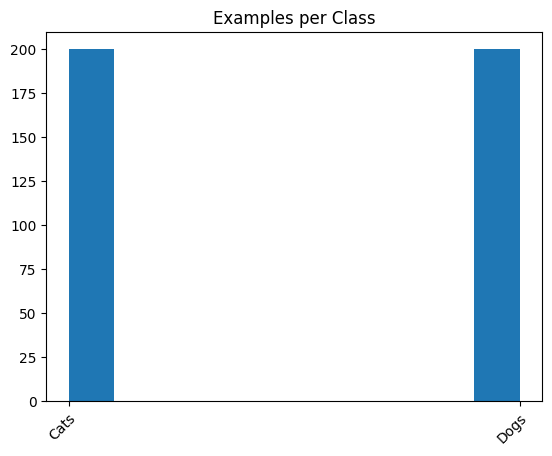

In [39]:
# Number of examples per class

labels_counter = collections.Counter(y_data)
print(collections.OrderedDict(sorted(labels_counter.items())))

ax = plt.subplot()
ax.hist(y_data, bins="auto")
plt.xticks(range(2))
ax.set_xticklabels(classes, rotation=45, rotation_mode="anchor", ha="right")
plt.title("Examples per Class")
plt.show()

Number of batches seen: 1


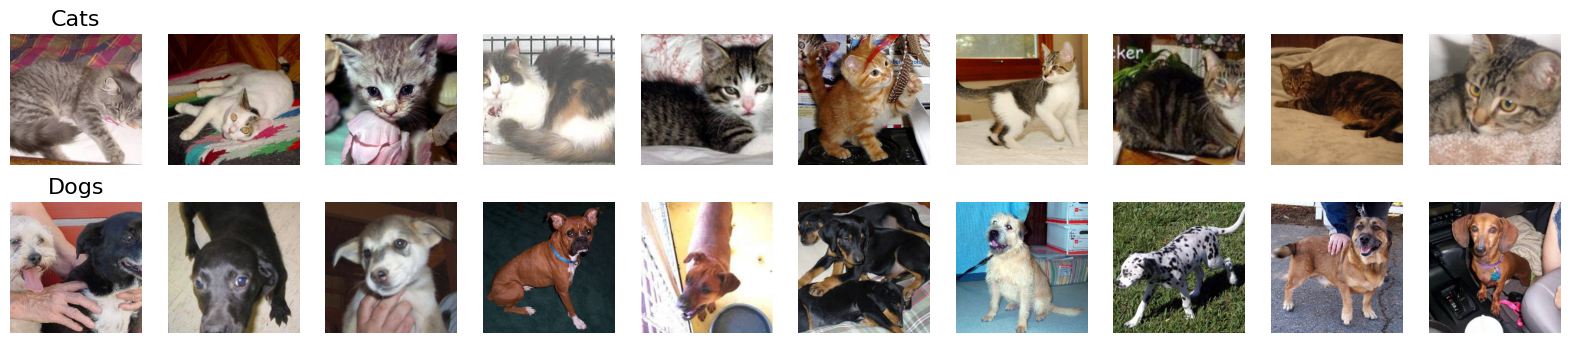

In [40]:
# Images in Grid Format

number_of_classes = len(classes)
number_of_images_per_class = 10

#fig, axes = plt.subplots(number_of_classes, number_of_images_per_class)#, figsize=(2, 20))
fig = plt.figure(figsize=(20, 4))

# Keep track of instances found
instances_per_class = {}
remaining_instances_to_be_found = set(range(number_of_classes))

# Traverse through the training set to find the 1st instances per class (number_of_images_per_class)
for iteration, (X_batch, y_batch) in enumerate(train_dataldr):    
    for X, y in zip(X_batch, y_batch):
        
        # Format inputs
        X = X.asnumpy()
        y = y.asnumpy().item()

        if y in instances_per_class and instances_per_class[y] == 10:
            if y in remaining_instances_to_be_found:
                remaining_instances_to_be_found.remove(y)
            continue
        
        if y not in instances_per_class:
            instances_per_class[y] = 0
            axes = fig.add_subplot(2, 10, y * 10 + 1)
            axes.set_title(classes[y], fontsize=16)
        else:
            axes = fig.add_subplot(2, 10, y * 10 + instances_per_class[y] + 1)

        axes.imshow(X)
        axes.axis('off')

        instances_per_class[y] += 1

    if not remaining_instances_to_be_found:
        # We are done
        break

print("Number of batches seen:", iteration + 1)

In [41]:
# python3 -m pip install pandas
# python3 -m pip install seaborn
# python3 -m pip install scikit-learn

import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA

In [42]:
# PCA Calculation (2 components)
pca = PCA(n_components=2)

pca_df = pd.DataFrame(columns=["x", "y", "class"])

pca_result = pca.fit_transform(X_data)

new_df = pd.DataFrame({
    "x": pca_result[:, 0],
    "y": pca_result[:, 1],
    "class": y_data
    })

pca_df = pca_df.append(new_df, ignore_index=True)

/tmp/ipykernel_3705400/356783051.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pca_df = pca_df.append(new_df, ignore_index=True)


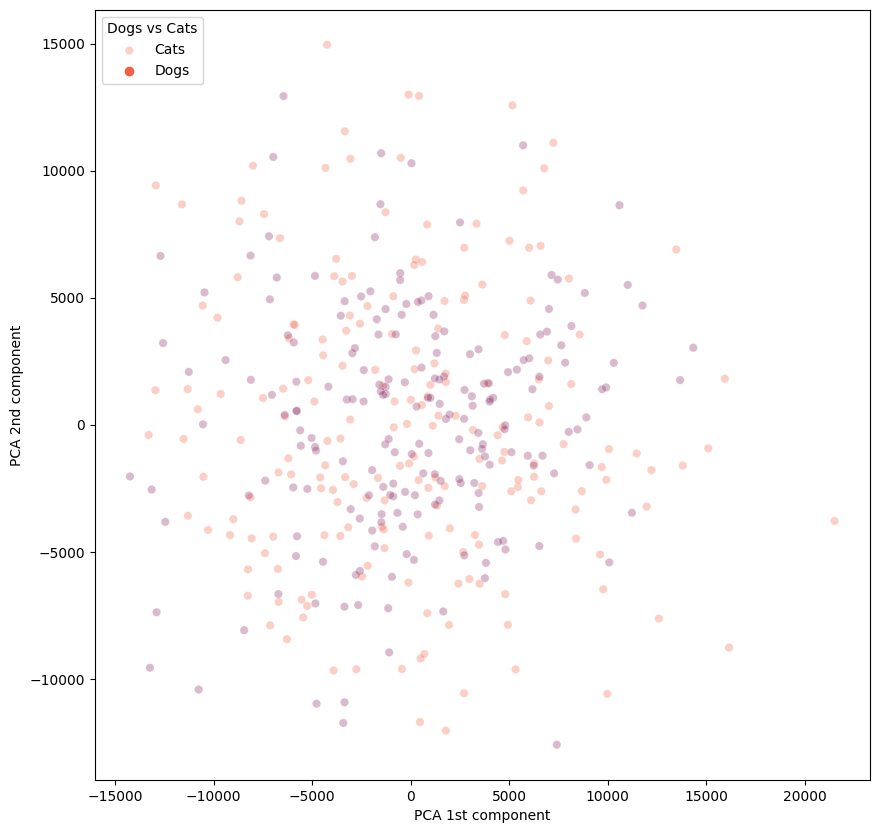

In [43]:
# PCA 2D Plot
plt.figure(figsize=(10, 10))

sns.scatterplot(
    data = pca_df,
    x = "x",
    y = "y",
    hue = "class",
    palette = sns.color_palette("rocket_r", 2),
    legend = "full",
    alpha = 0.3
)

# Modify Legend and Labels
plt.legend(classes, title = "Dogs vs Cats", loc="upper left")
plt.xlabel("PCA 1st component")
plt.ylabel("PCA 2nd component")

plt.show()

In [44]:
from sklearn.manifold import TSNE

In [45]:
pca = PCA(n_components=50)
pca_result = pca.fit_transform(X_data)

tsne = TSNE(n_components=2)
tsne_df = pd.DataFrame(columns=["x", "y", "class"])

tsne_result = tsne.fit_transform(pca_result)

new_df = pd.DataFrame({
    "x": tsne_result[:, 0],
    "y": tsne_result[:, 1],
    "class": y_data
    })
tsne_df = tsne_df.append(new_df, ignore_index=True)

/tmp/ipykernel_3705400/2017218383.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tsne_df = tsne_df.append(new_df, ignore_index=True)


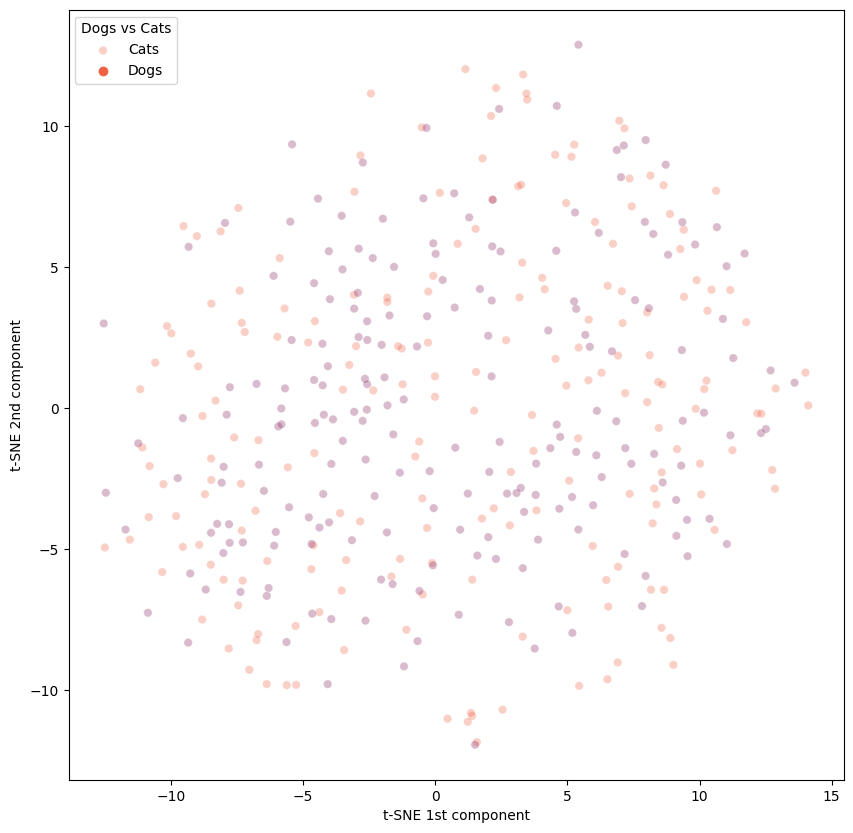

In [46]:
# t-SNE Plot
plt.figure(figsize=(10, 10))

sns.scatterplot(
    data = tsne_df,
    x = "x",
    y = "y",
    hue = "class",
    palette = sns.color_palette("rocket_r", 2),
    legend = "full",
    alpha = 0.3
)

# Modify Legend and Labels
plt.legend(classes, title = "Dogs vs Cats", loc="upper left")
plt.xlabel("t-SNE 1st component")
plt.ylabel("t-SNE 2nd component")

plt.show()

In [47]:
# python3 -m pip install umap-learn

import umap

In [48]:
embedding = umap.UMAP(n_neighbors=5).fit_transform(X_data)

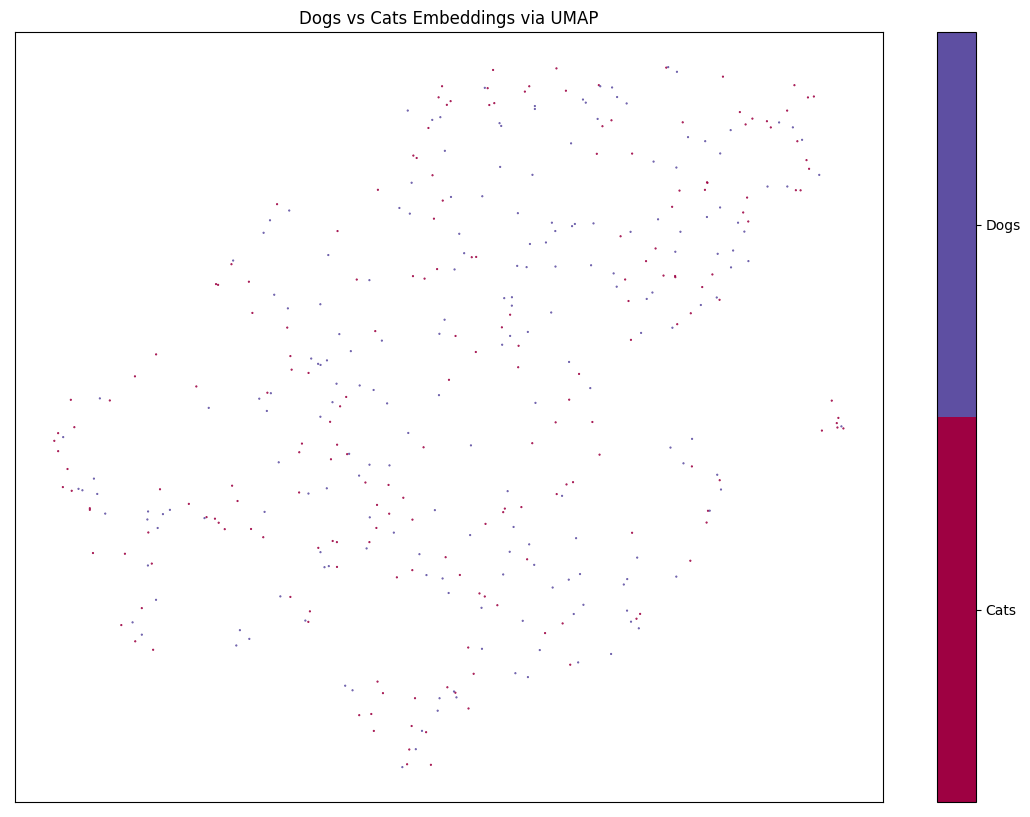

In [49]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding.T, s=0.3, c=y_data, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(3)-0.5)
cbar.set_ticks(np.arange(2))
cbar.set_ticklabels(classes)
plt.title('Dogs vs Cats Embeddings via UMAP');

In [56]:
# Generate DataLoader with pre-processing for ImageNet for model inputs (light dataset version)
imageNet=True
light=True
train_dataset, val_dataset, test_dataset = utils.generate_cats_vs_dogs_datasets(path, light=light, imageNet=imageNet)
train_dataldr, _, test_dataldr = utils.generate_cats_vs_dogs_dataloaders(train_dataset, None, test_dataset, batch_size=256)


In [89]:
import model
reload(model)

alexnet = model.create_alexnet_network(num_classes = 2)
alexnet.collect_params().initialize(mx.init.MSRAPrelu(), ctx=ctx, force_reinit=True)

In [121]:
reload(model)

# Define Loss Function (Binary, cats vs dogs)
#loss_fn = mx.gluon.loss.SigmoidBinaryCrossEntropyLoss()
loss_fn = mx.gluon.loss.SoftmaxCrossEntropyLoss()

# Epochs & Batch Size
# Optimal values for full: "adam", lr: 0.01, 10+ epochs, batch size 256
# Optimal values for light: "adam", lr: 0.0001, 10+ epochs, batch size 16
epochs = 20
batch_size = 16
alexnet.collect_params().initialize(mx.init.MSRAPrelu(), ctx=ctx, force_reinit=True)

# Define Optimizer and Hyper Parameters
trainer = mx.gluon.Trainer(alexnet.collect_params(), "adam", {"learning_rate": 0.0001})

training_loss, validation_loss, validation_acc, training_acc = model.training_loop(alexnet,
                                                                                   loss_fn,
                                                                                   trainer,
                                                                                   epochs,
                                                                                   batch_size,
                                                                                   train_dataset,
                                                                                   val_dataset,
                                                                                   ctx)

E:    1, TrL: 0.864533, TrAcc: 0.487500, VL: 0.723008, VAcc: 0.465000 --- Updating saved model
E:    2, TrL: 0.694263, TrAcc: 0.547500, VL: 0.705061, VAcc: 0.550000 --- Updating saved model
E:    3, TrL: 0.670600, TrAcc: 0.557500, VL: 0.699079, VAcc: 0.545000
E:    4, TrL: 0.640456, TrAcc: 0.595000, VL: 0.651882, VAcc: 0.605000 --- Updating saved model
E:    5, TrL: 0.626483, TrAcc: 0.632500, VL: 0.676118, VAcc: 0.590000
E:    6, TrL: 0.566511, TrAcc: 0.681250, VL: 0.714167, VAcc: 0.670000 --- Updating saved model
E:    7, TrL: 0.549594, TrAcc: 0.706250, VL: 0.635372, VAcc: 0.680000 --- Updating saved model
E:    8, TrL: 0.495329, TrAcc: 0.751250, VL: 0.568191, VAcc: 0.745000 --- Updating saved model
E:    9, TrL: 0.463398, TrAcc: 0.762500, VL: 0.659968, VAcc: 0.655000
E:   10, TrL: 0.415893, TrAcc: 0.795000, VL: 0.708053, VAcc: 0.675000
E:   11, TrL: 0.362495, TrAcc: 0.825000, VL: 0.546145, VAcc: 0.785000 --- Updating saved model
E:   12, TrL: 0.275133, TrAcc: 0.890000, VL: 0.684591, 

In [126]:
# Load best model trained
alexnet.load_parameters(model.MODEL_FILE_NAME)

In [127]:
# Run testset through our network (AlexNet)
expected_outputs = []
class_outputs = []

acc = mx.metric.Accuracy()

for images, labels in test_dataldr:
    output = alexnet(images.as_in_context(ctx))

    class_output_imagenet = np.argmax(output, axis=1)
    class_output = class_output_imagenet
    
    acc.update(labels, class_output)
    
    expected_outputs += labels.tolist()
    class_outputs += class_output.asnumpy().tolist()

In [128]:
print(acc.get())

('accuracy', 0.7275)


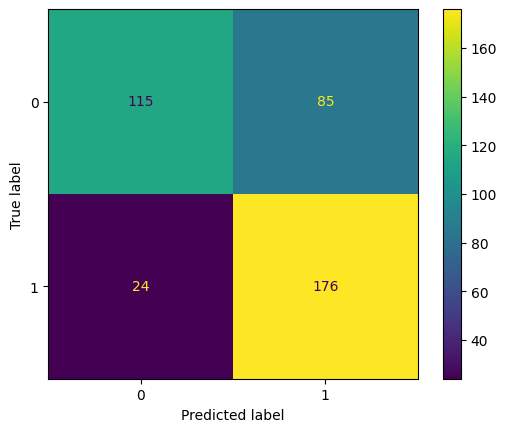

In [129]:
# Confusion Matrix
confusion_matrix = metrics.confusion_matrix(expected_outputs, class_outputs)
cm_disp = metrics.ConfusionMatrixDisplay(confusion_matrix)
cm_disp.plot()

In [130]:
# AlexNet from Model Zoo (This downloads v1d)
# Requires disabling NumPy Semantics
mx.npx.reset_np()

# By disabling np semantics, we also need to reload datasets
# Generate DataLoader with pre-processing for ImageNet (light dataset version)
imageNet=True
light=True
train_dataset_npx, val_dataset_npx, test_dataset_npx = utils.generate_cats_vs_dogs_datasets(path, light=light, imageNet=imageNet)
_, _, test_dataldr_npx = utils.generate_cats_vs_dogs_dataloaders(None, None, test_dataset_npx, batch_size=32)

alexnet_npx = gcv.model_zoo.get_model("alexnet", pretrained=True, ctx=ctx)

In [131]:
# Run testset through our network (AlexNet)
expected_outputs = []
class_outputs = []

acc = mx.metric.Accuracy()

for images, labels in test_dataldr_npx:
    output = alexnet_npx(images.as_in_context(ctx))
    
    class_output_imagenet = np.argmax(output, axis=1)    
    class_output = mx.nd.array([classes_dict[idx] for idx in class_output_imagenet.asnumpy()])
    
    acc.update(labels, class_output)
    
    expected_outputs += labels.asnumpy().tolist()
    class_outputs += class_output.asnumpy().tolist()

In [132]:
print(acc.get())

('accuracy', 0.725)


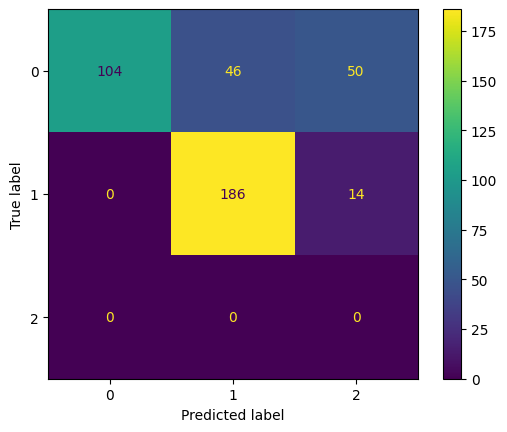

In [133]:
# Confusion Matrix
confusion_matrix = metrics.confusion_matrix(expected_outputs, class_outputs)
cm_disp = metrics.ConfusionMatrixDisplay(confusion_matrix)
cm_disp.plot()

In [135]:
# Back to NumPy Semantics
mx.npx.set_np()

# ResNet50 from Model Zoo (This downloads v1d)
resnet50 = gcv.model_zoo.get_model("resnet50_v1d", pretrained=True, ctx=ctx)

# Generate DataLoader with pre-processing for ImageNet (light dataset version)
imageNet=True
light=True
train_dataset, val_dataset, test_dataset = utils.generate_cats_vs_dogs_datasets(path, light=light, imageNet=imageNet)
_, _, test_dataldr = utils.generate_cats_vs_dogs_dataloaders(None, None, test_dataset, batch_size=32)

In [136]:
# Run testset through our network (ResNet50)
expected_outputs = []
class_outputs = []

acc = mx.metric.Accuracy()
f1  = mx.metric.F1()

for images, labels in test_dataldr:
    output = resnet50(images.as_in_context(ctx))
    
    class_output_imagenet = np.argmax(output, axis=1)
    class_output = mx.nd.array([classes_dict[idx] for idx in class_output_imagenet.asnumpy()])
    
    acc.update(labels, class_output)
    
    expected_outputs += labels.tolist()
    class_outputs += class_output.asnumpy().tolist()

[18:17:09] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:96: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


In [138]:
print(acc.get())

('accuracy', 0.925)


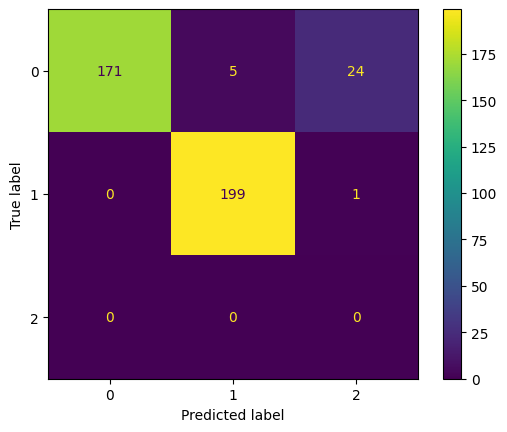

In [139]:
# Confusion Matrix
confusion_matrix = metrics.confusion_matrix(expected_outputs, class_outputs)
cm_disp = metrics.ConfusionMatrixDisplay(confusion_matrix)
cm_disp.plot()